## Projeto para Disciplina de Mineração de Dados  
## Aplicação de Técnica de Classificação para Solução de Captcha  Sonoro
### Programa de Pós Graduação em Computação UFABC - 2º Quadrimestre de 2018
#### Integrantes:
Erick Fernandes da Cruz <br>
Gustavo Borges Lugoboni


### 1 - Introdução
Segundo o artigo de Gantz (2012) o crescimento de na quantidade de dados ocorre de forma exponencial e até 2020 poderemos chegar a quantidade de 40 trilhões de Gigabytes de dados, e neste contexto as técnicas de Mineração de Dados (Data Mining) apresentam ferramentas para encontrarmos relações desconhecidas e para sumarizar os dados em formas que sejam compreensíveis e úteis, o que dificilmente seria feito sem a utilização de técnicas adequadas.

Durante a disciplina foram estudadas diversas técnicas utilizadas em Mineração de Dados, algoritmos de regressão e classificação, porém o presente projeto se limita ao estudo dos algoritmos de classificação. Os problemas de classificação tem como objetivo principal identificar qual a classe mais que um novo dado deve ser classificado.

Neste trabalho utilizaremos algoritmos de classificação para classificar de forma adequada um conjunto de arquivos wav que possuem em 4 caracteres sendo falados por arquivo, onde os possíveis caracteres são a,b,c,d,h,m,n,x,6,7. Para isso teremos um conjunto de arquivos treinamento e um conjunto de arquivos de validação. Nosso objetivo é através da utilização de um algoritmo de classificação conseguir inferir corretamente as letras que estão contidas em cada um dos arquivos wav do conjunto de validação.

Para o desenvolvimento do projeto foi utilizada a linguagem Python (Versão 3.5.2) e para auxiliar o desenvolvimento utilizamos algumas bibliotecas para auxiliar no desenvolvimento. Dentre essa bibliotecas utilizamos a Numpy e Scipy que auxilia em vários cálculos realizados e manipulações de Arrays, a biblioteca Librosa que apresenta ferramentas para manipulação de arquivos de aúdio e a bilioteca Sklearn que possui um grande número de técnicas de Mineração de Dados que foram aproveitadas neste projeto.  

No trecho de código a seguir é possível realizar as importações das bibliotecas que serão utilizadas no decorrer do projeto.

In [112]:
#Bibliotecas utilizadas

import os
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import IPython.display as ipd
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.externals import joblib

from bokeh.models import CDSView, ColumnDataSource, GroupFilter
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

### 2 - Análise Exploratória
A base de dados estudada possuía alguns problemas que necessitaram de certas transformações para facilitar a obtenção dos atributos. A primeira etapa segmentar o arquivo wav de forma a obter 4 partes correspondentes a cada carácter do arquivo. Para isso inicialmente separamos o arquivo em 4 partes iguais, visto que a duração dos arquivos de áudio que compunham o captcha possuíam tamanhos iguais.

Após esta separação, a próximo etapa foi separar os trechos onde apenas continha ruído de fundo do trecho que o carácter é falada. Para isto segmentamos o áudio em pequenos subconjuntos e analisamos os picos de frequência em cada uma delas, calculando a partir disso uma frequência de corte entre que separasse o carácter do ruído de fundo. Utilizamos em seguida a frequência de corte para verificar os subconjuntos que possuíam um frequência maior e unimos os conjuntos com estas características que estivessem a uma distancia de no máximo 2 conjuntos. Com os subconjuntos unidos verificamos qual a união de subconjuntos possuía o maior número de elementos e consideramos esta como a parte correspondente ao carácter.

Após identificarmos o exato pedaço correspondente de cada carácter, a transformação seguinte teve como objetivo remover o ruído de fundo que estava presente no próprio carácter. Para isso subtraímos da região correspondente as frequências dos caracteres pela frequência de corte correspondente ao ruído de fundo de cada áudio.

Por fim verificamos que devido a diferença de volume dos áudios, apesar de um mesmo carácter possuir uma curva de frequência semelhante, os diferentes volumes tornavam os valores dessas frequências muito distintos. Para contornamos este problema normalizamos os valores de frequência correspondentes a cada carácter entre -1 e 1.

A seguir é possível verificar o código utilizado para a realização das manipulações citadas acima, sendo este primeiro trecho corresponde aos Arrays que foram criados para obter respectivamente a onda e ao char de cada carácter do conjunto de treinamento.

In [2]:
WaveLetters = list()
Y = list()

A função a seguir recebe um Array com os valores de frequências correspondentes a cada carácter e devolve como saída o mesmo Array com os valores de frequência normalizados entre -1 e 1.

In [3]:
def normalizar(data) :
    
    #Definir valor máximo
    maximo = 0;
    if (max(data) > np.absolute(min(data))):
        maximo = max(data)
    else: 
        maximo = np.absolute(min(data))
    
    #Normalizar vetor entre -1 e 1
    x = 0
    while(x < len(data)):
        data[x] = data[x]/maximo
        x += 1
    
    return data

A função separar_caracter recebe como entrada o Array correspondente ao captcha contendo 4 caracteres e o Array onde estão sendo armazenadas os caracteres separados. O está função realiza o processo de separar os caracteres do arquivo, remover o ruído contido no carácter e aplicar a função de normalização mostrada anteriormente, e por fim armazena os 4 segmentos corresponde aos caracteres em um Array que irá armazenar as saídas de todos os captchas de cada conjunto.

In [31]:
def separar_caracter(data, destination_array) :

    #Separar em 4 conjuntos 
    splited = []
    for i in range(4):
        start = int(i*len(data)/4)
        end = int((i+1)*len(data)/4)
        splited.append(data[start:end])
    
    frame_lenght = 3150 # frames de fs/14 aprox 0.5s
    
    chars_values = list()
    
    for audioPart in range(4):
        initial_frame_pos = 0 
        frames_list = list()

        #Separando os frames
        while initial_frame_pos < len(splited[audioPart]):
            frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
            initial_frame_pos += frame_lenght

        #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
        amp_cat_values = list()

        max_values = [max(x) for x in frames_list] 
        max_values.sort()
        max_value_mean = np.mean(max_values)
        max_value_std = np.std(max_values)

        for frame in frames_list:
            frame_max = max(abs(frame))
            #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
            if frame_max <= max_value_mean + max_value_std**2 :  
                if frame_max >= max_value_mean - max_value_std**2 :
                    amp_cat_values.append("max")
                else:
                    amp_cat_values.append("min")
            else:
                amp_cat_values.append("max")

        # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
        max_indexes = list()
        index_list = range(0, len(amp_cat_values))
        amp_cat_values = list(zip(index_list, amp_cat_values))

        max_indexes = [index for index in amp_cat_values if index[1] is "max"]

        #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
        chars_indexes = list()
        new_frame = list()
        new_frame.append(max_indexes[0])
        for frame_info in max_indexes:
            if frame_info[0] - new_frame[-1][0] <= 2:
                if frame_info not in new_frame:
                    new_frame.append(frame_info)
            else:
                chars_indexes.append(new_frame)
                new_frame = list()
                new_frame.append(frame_info)
            if frame_info is max_indexes[-1]:
                chars_indexes.append(new_frame)

        # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
        # caracteres validos
        initialBigger = 0
        lastBigger = 0

        diferenca = 0

        for index in chars_indexes:
            initial = index[0][0] 
            last = index[-1][0] 

            if (last - initial) > diferenca:
                initialBigger = initial
                lastBigger = last

        if (initialBigger != 0):
            initialBigger = initialBigger - 1
    
        #Obter uma frequencia de corte baseada em um conjunto que possui apenas o ruído
        
        corte = 0
        if (initialBigger != 0):
            corte = max(frames_list[initialBigger - 1])
        else:     
            corte = max(frames_list[lastBigger + 2])
            
        value = np.hstack(frames_list[initialBigger:lastBigger+1])
        
        #Remover o ruído com base no corte obtido anteriormente
        variavel = 0
        while(variavel < len(value)):
            if value[variavel] < 0:
                if corte > np.absolute(value[variavel]):
                    value[variavel] = 0
                else: 
                    value[variavel] = value[variavel] + corte
            else: 
                if corte > value[variavel]:
                    value[variavel] = 0
                else:
                    value[variavel] = value[variavel] - corte
            
            variavel = variavel+1
        
        destination_array.append(normalizar(value))

Com as funções criadas, o próximo passo era aplicar a função por toda a base de treinamente. O trecho de código a seguir acessa a pasta da base de treinamento e aplica a função de separação de caracteres, além de separarmos o char correspondente a cada carácter do nome do arquivo e armazená-los no Array Y.

In [32]:
for root, dirs, files in os.walk("base_treinamento_I/"):  
    
    for filename in files:
        
        data, fs = librosa.load('base_treinamento_I/' + filename, None)
        for s in range(4):
            Y.append(filename[s])
            
        separar_caracter(data, WaveLetters)

Após aplicarmos as transformações necessárias para que nossa base de dados tivesse a maior parte do ruído do áudio removido e a seguimentação dos caracteres realizada, a etapa seguinte foi o levantamento de possíveis atributos para utilizarmos nos algoritmos de classificação.

Dentre os atributos que utilizamos podemos citar a duração do áudio, batidas por minuto, média da frequência, média do centroide, quartis e média das frequências por segmento do áudio. A extração desses atributos podem ser visualizados no código abaixo. 

In [90]:
#extraindo atributos
duration = np.array([len(x)/fs for x in WaveLetters])

tempo_beat = [librosa.beat.beat_track(y=x, sr=fs) for x in WaveLetters]
tempo = np.array([x[0] for x in tempo_beat])
beat_frame = np.array([x[1] for x in tempo_beat])

mean_percussive = np.array([librosa.effects.hpss(x)[1].mean() for x in WaveLetters])

#sftf = [librosa.stft(x) for x in WaveLetters]
fourier = [np.fft.fft(x) for x in WaveLetters]
mean_freq = np.array([np.abs(x).mean() for x in fourier])

mean_centroid = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in WaveLetters]

freq_QT50 = [np.percentile(np.abs(x), 50) for x in fourier]
freq_QT75 = [np.percentile(np.abs(x), 75) for x in fourier]
freq_QT25 = [np.percentile(np.abs(x), 25) for x in fourier]

#Médias
mean_0_20 = []
mean_20_40 = []
mean_40_60 = []
mean_60_80 = []
mean_80_100 = []

for x in WaveLetters:
     
    splited = []
    for i in range(5):
        start = int(i*len(x)/5)
        end = int((i+1)*len(x)/5)
        splited.append(x[start:end])
    
    mean_0_20.append(np.mean(np.absolute(splited[0])))
    mean_20_40.append(np.mean(np.absolute(splited[1])))
    mean_40_60.append(np.mean(np.absolute(splited[2])))
    mean_60_80.append(np.mean(np.absolute(splited[3])))
    mean_80_100.append(np.mean(np.absolute(splited[4])))
    
train_base = np.array(list(zip(
    duration,
    tempo, 
    mean_percussive, 
    mean_freq, 
    mean_centroid, 
    freq_QT50, 
    freq_QT75, 
    freq_QT25,
    mean_0_20,
    mean_20_40,
    mean_40_60,
    mean_60_80,
    mean_80_100)))

Após a obtenção dos atributos na base de treinamento, o mesmo processo foi realizado com a base de validação, para que pudéssemos em seguida utilizar os atributos obtidos nos algoritmos de classificação.

In [91]:
#carregando base de validação
Array_test = list()
Y_test = list()
for root, dirs, files in os.walk("base_validacao_I/"):  
    
    for filename in files:
        
        data, fs = librosa.load('base_validacao_I/' + filename, None)
        for s in range(4):
            Y_test.append(filename[s])
            
        separar_caracter(data, Array_test)

In [92]:
#extraindo informações
duration_test = np.array([len(x)/fs for x in Array_test])

tempo_beat_test = [librosa.beat.beat_track(y=x, sr=fs) for x in Array_test]
tempo_test = np.array([x[0] for x in tempo_beat_test])
beat_frame_test = np.array([x[1] for x in tempo_beat_test])

mean_percussive_test = np.array([librosa.effects.hpss(x)[1].mean() for x in Array_test])

#sftf_test = [librosa.stft(x) for x in Array_test]
fourier_test = [np.fft.fft(x) for x in Array_test]
mean_freq_test = np.array([np.abs(x).mean() for x in fourier_test])
freq_QT50_test = [np.percentile(np.abs(x), 50) for x in fourier_test]
freq_QT75_test = [np.percentile(np.abs(x), 75) for x in fourier_test]
freq_QT25_test = [np.percentile(np.abs(x), 25) for x in fourier_test]

mean_centroid_test = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in Array_test]

#Médias
mean_0_20_test = []
mean_20_40_test = []
mean_40_60_test = []
mean_60_80_test = []
mean_80_100_test = []

for x in Array_test:
     
    splited = []
    for i in range(5):
        start = int(i*len(x)/5)
        end = int((i+1)*len(x)/5)
        splited.append(x[start:end])
    
    mean_0_20_test.append(np.mean(np.absolute(splited[0])))
    mean_20_40_test.append(np.mean(np.absolute(splited[1])))
    mean_40_60_test.append(np.mean(np.absolute(splited[2])))
    mean_60_80_test.append(np.mean(np.absolute(splited[3])))
    mean_80_100_test.append(np.mean(np.absolute(splited[4])))

test_base = np.array(list(zip(
    duration_test,
    tempo_test, 
    mean_percussive_test, 
    mean_freq_test, 
    mean_centroid_test, 
    freq_QT50_test, 
    freq_QT75_test, 
    freq_QT25_test,
    mean_0_20_test,
    mean_20_40_test,
    mean_40_60_test,
    mean_60_80_test,
    mean_80_100_test)))


### 3 - Metodologia
Após a obtenção dos possíveis atributos que poderiamos utilizar de nossa base de dados, foram testadas combinações entre esses atributos verificando qual a combinação apresentava um melhor resultado para classificar a base de validação. A partir desses testes foi verificado que a combinação que apresentou um melhor resultado foi a união de todos os atributos levantados.

Após identificarmos os atributos que seriam utilizados, precisavamos selecionar um algoritmo de classificação que tivesse uma maior taxa de acerto em nossa base de validação. Para isso submetemos nossas bases de treinamento e validação em diversos algoritmos oferecidos pela biblioteca Sklearn, e verificamos que o algoritmo que obteve a maior taxa de acerto foi o "NOME DO ALGORITMO UTILIZADO NA CLASSIFICAÇÃO AQUI".

Para a avaliação dos resultados utilizamos dois tipos de métricas diferentes. A primeira foi avaliar individualmente os caracteres que foram expostos ao algoritmo de classificação, verificando qual a porcentagem de caracteres que o algoritmo conseguiu classificar corretamente. A segunda avaliação foi a obtenção da porcentagem de Captchas de 4 caracteres o algoritmo conseguiu classificar todos os caracteres sem nenhum erro.

## Podemos separar esse trecho do texto mostrando as etapas que utilizamos para obter as informações, mostrando o resultado que utilizamos para a seleção do algoritmo e atributos utilizados.

In [93]:
#Criando bases de cada letra a,b,c,d,h,m,n,x,6,7

a_base = list()
b_base = list()
c_base = list()
d_base = list()
h_base = list()
m_base = list()
n_base = list()
x_base = list()
si_base = list()
se_base = list()
labels = [
    'duration',
    'tempo', 
    'mean_percussive', 
    'mean_freq', 
    'mean_centroid', 
    'freq_QT50', 
    'freq_QT75', 
    'freq_QT25',
    'mean1',
    'mean2',
    'mean3',
    'mean4',
    'mean5']

for i in range(0, len(Y)):
    if Y[i] == 'a':
        a_base.append(train_base[i])
    elif Y[i] == 'b':
        b_base.append(train_base[i])
    elif Y[i] == 'c':
        c_base.append(train_base[i])
    elif Y[i] == 'd':
        d_base.append(train_base[i])
    elif Y[i] == 'h':
        h_base.append(train_base[i])
    elif Y[i] == 'm':
        m_base.append(train_base[i])
    elif Y[i] == 'n':
        n_base.append(train_base[i])
    elif Y[i] == 'x':
        x_base.append(train_base[i])
    elif Y[i] == '6':
        si_base.append(train_base[i])
    elif Y[i] == '7':
        se_base.append(train_base[i])
    else:
        pass

a_base = pd.DataFrame.from_records(a_base, columns=labels)
b_base = pd.DataFrame.from_records(b_base, columns=labels)
c_base = pd.DataFrame.from_records(c_base, columns=labels)
d_base = pd.DataFrame.from_records(d_base, columns=labels)
h_base = pd.DataFrame.from_records(h_base, columns=labels)
m_base = pd.DataFrame.from_records(m_base, columns=labels)
n_base = pd.DataFrame.from_records(n_base, columns=labels)
x_base = pd.DataFrame.from_records(x_base, columns=labels)
si_base = pd.DataFrame.from_records(si_base, columns=labels)
se_base = pd.DataFrame.from_records(se_base, columns=labels)


#Base de teste

a_base_test = list()
b_base_test = list()
c_base_test = list()
d_base_test = list()
h_base_test = list()
m_base_test = list()
n_base_test = list()
x_base_test = list()
si_base_test = list()
se_base_test = list()

for i in range(0, len(Y_test)):
    if Y[i] == 'a':
        a_base_test.append(test_base[i])
    elif Y[i] == 'b':
        b_base_test.append(test_base[i])
    elif Y[i] == 'c':
        c_base_test.append(test_base[i])
    elif Y[i] == 'd':
        d_base_test.append(test_base[i])
    elif Y[i] == 'h':
        h_base_test.append(test_base[i])
    elif Y[i] == 'm':
        m_base_test.append(test_base[i])
    elif Y[i] == 'n':
        n_base_test.append(test_base[i])
    elif Y[i] == 'x':
        x_base_test.append(test_base[i])
    elif Y[i] == '6':
        si_base_test.append(test_base[i])
    elif Y[i] == '7':
        se_base_test.append(test_base[i])
    else:
        pass

a_base_test = pd.DataFrame.from_records(a_base_test, columns=labels)
b_base_test = pd.DataFrame.from_records(b_base_test, columns=labels)
c_base_test = pd.DataFrame.from_records(c_base_test, columns=labels)
d_base_test = pd.DataFrame.from_records(d_base_test, columns=labels)
h_base_test = pd.DataFrame.from_records(h_base_test, columns=labels)
m_base_test = pd.DataFrame.from_records(m_base_test, columns=labels)
n_base_test = pd.DataFrame.from_records(n_base_test, columns=labels)
x_base_test = pd.DataFrame.from_records(x_base_test, columns=labels)
si_base_test = pd.DataFrame.from_records(si_base_test, columns=labels)
se_base_test = pd.DataFrame.from_records(se_base_test, columns=labels)


# ANALISE EXPLORATORIA

In [94]:
output_notebook()
#histogramas
#mean_freq
a_mean_freq_hist, edges_a = np.histogram(a_base.mean_freq, density=True)
b_mean_freq_hist, edges_b = np.histogram(b_base.mean_freq, density=True)
c_mean_freq_hist, edges_c = np.histogram(c_base.mean_freq, density=True)
d_mean_freq_hist, edges_d = np.histogram(d_base.mean_freq, density=True)
h_mean_freq_hist, edges_h = np.histogram(h_base.mean_freq, density=True)
m_mean_freq_hist, edges_m = np.histogram(m_base.mean_freq, density=True)
n_mean_freq_hist, edges_n = np.histogram(n_base.mean_freq, density=True)
x_mean_freq_hist, edges_x = np.histogram(x_base.mean_freq, density=True)
si_mean_freq_hist, edges_si = np.histogram(si_base.mean_freq, density=True)
se_mean_freq_hist, edges_se = np.histogram(se_base.mean_freq, density=True)

fig_a_mean_freq_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_mean_freq_hist.quad(top=a_mean_freq_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_mean_freq_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_mean_freq_hist.quad(top=b_mean_freq_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_mean_freq_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_mean_freq_hist.quad(top=c_mean_freq_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_mean_freq_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_mean_freq_hist.quad(top=d_mean_freq_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_mean_freq_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_mean_freq_hist.quad(top=h_mean_freq_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_mean_freq_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_mean_freq_hist.quad(top=m_mean_freq_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_mean_freq_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_mean_freq_hist.quad(top=n_mean_freq_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_mean_freq_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_mean_freq_hist.quad(top=x_mean_freq_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_mean_freq_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_mean_freq_hist.quad(top=si_mean_freq_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_mean_freq_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_mean_freq_hist.quad(top=se_mean_freq_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean_freq_hist, fig_b_mean_freq_hist, fig_c_mean_freq_hist], 
                [fig_d_mean_freq_hist, fig_h_mean_freq_hist, fig_m_mean_freq_hist], 
                [fig_n_mean_freq_hist, fig_x_mean_freq_hist, fig_si_mean_freq_hist], 
                [fig_se_mean_freq_hist]], title='MEAN_FREQ', notebook_handle=True)
show(plt)

Loading BokehJS ...

In [95]:
#freq_QT50 histograma
a_freq_QT50_hist, edges_a = np.histogram(a_base.freq_QT50, density=True)
b_freq_QT50_hist, edges_b = np.histogram(b_base.freq_QT50, density=True)
c_freq_QT50_hist, edges_c = np.histogram(c_base.freq_QT50, density=True)
d_freq_QT50_hist, edges_d = np.histogram(d_base.freq_QT50, density=True)
h_freq_QT50_hist, edges_h = np.histogram(h_base.freq_QT50, density=True)
m_freq_QT50_hist, edges_m = np.histogram(m_base.freq_QT50, density=True)
n_freq_QT50_hist, edges_n = np.histogram(n_base.freq_QT50, density=True)
x_freq_QT50_hist, edges_x = np.histogram(x_base.freq_QT50, density=True)
si_freq_QT50_hist, edges_si = np.histogram(si_base.freq_QT50, density=True)
se_freq_QT50_hist, edges_se = np.histogram(se_base.freq_QT50, density=True)

fig_a_freq_QT50_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_freq_QT50_hist.quad(top=a_freq_QT50_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_freq_QT50_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_freq_QT50_hist.quad(top=b_freq_QT50_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_freq_QT50_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_freq_QT50_hist.quad(top=c_freq_QT50_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_freq_QT50_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_freq_QT50_hist.quad(top=d_freq_QT50_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_freq_QT50_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_freq_QT50_hist.quad(top=h_freq_QT50_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_freq_QT50_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_freq_QT50_hist.quad(top=m_freq_QT50_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_freq_QT50_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_freq_QT50_hist.quad(top=n_freq_QT50_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_freq_QT50_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_freq_QT50_hist.quad(top=x_freq_QT50_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_freq_QT50_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_freq_QT50_hist.quad(top=si_freq_QT50_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_freq_QT50_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_freq_QT50_hist.quad(top=se_freq_QT50_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_freq_QT50_hist, fig_b_freq_QT50_hist, fig_c_freq_QT50_hist], 
                [fig_d_freq_QT50_hist, fig_h_freq_QT50_hist, fig_m_freq_QT50_hist], 
                [fig_n_freq_QT50_hist, fig_x_freq_QT50_hist, fig_si_freq_QT50_hist], 
                [fig_se_freq_QT50_hist]], title='freq_QT50', notebook_handle=True)
show(plt)

In [96]:
#freq_QT25 histograma
a_freq_QT25_hist, edges_a = np.histogram(a_base.freq_QT25, density=True)
b_freq_QT25_hist, edges_b = np.histogram(b_base.freq_QT25, density=True)
c_freq_QT25_hist, edges_c = np.histogram(c_base.freq_QT25, density=True)
d_freq_QT25_hist, edges_d = np.histogram(d_base.freq_QT25, density=True)
h_freq_QT25_hist, edges_h = np.histogram(h_base.freq_QT25, density=True)
m_freq_QT25_hist, edges_m = np.histogram(m_base.freq_QT25, density=True)
n_freq_QT25_hist, edges_n = np.histogram(n_base.freq_QT25, density=True)
x_freq_QT25_hist, edges_x = np.histogram(x_base.freq_QT25, density=True)
si_freq_QT25_hist, edges_si = np.histogram(si_base.freq_QT25, density=True)
se_freq_QT25_hist, edges_se = np.histogram(se_base.freq_QT25, density=True)

fig_a_freq_QT25_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_freq_QT25_hist.quad(top=a_freq_QT25_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_freq_QT25_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_freq_QT25_hist.quad(top=b_freq_QT25_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_freq_QT25_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_freq_QT25_hist.quad(top=c_freq_QT25_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_freq_QT25_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_freq_QT25_hist.quad(top=d_freq_QT25_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_freq_QT25_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_freq_QT25_hist.quad(top=h_freq_QT25_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_freq_QT25_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_freq_QT25_hist.quad(top=m_freq_QT25_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_freq_QT25_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_freq_QT25_hist.quad(top=n_freq_QT25_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_freq_QT25_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_freq_QT25_hist.quad(top=x_freq_QT25_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_freq_QT25_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_freq_QT25_hist.quad(top=si_freq_QT25_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_freq_QT25_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_freq_QT25_hist.quad(top=se_freq_QT25_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_freq_QT25_hist, fig_b_freq_QT25_hist, fig_c_freq_QT25_hist], 
                [fig_d_freq_QT25_hist, fig_h_freq_QT25_hist, fig_m_freq_QT25_hist], 
                [fig_n_freq_QT25_hist, fig_x_freq_QT25_hist, fig_si_freq_QT25_hist], 
                [fig_se_freq_QT25_hist]], title='freq_QT25', notebook_handle=True)
show(plt)

In [97]:
#freq_QT75 histograma
a_freq_QT75_hist, edges_a = np.histogram(a_base.freq_QT75, density=True)
b_freq_QT75_hist, edges_b = np.histogram(b_base.freq_QT75, density=True)
c_freq_QT75_hist, edges_c = np.histogram(c_base.freq_QT75, density=True)
d_freq_QT75_hist, edges_d = np.histogram(d_base.freq_QT75, density=True)
h_freq_QT75_hist, edges_h = np.histogram(h_base.freq_QT75, density=True)
m_freq_QT75_hist, edges_m = np.histogram(m_base.freq_QT75, density=True)
n_freq_QT75_hist, edges_n = np.histogram(n_base.freq_QT75, density=True)
x_freq_QT75_hist, edges_x = np.histogram(x_base.freq_QT75, density=True)
si_freq_QT75_hist, edges_si = np.histogram(si_base.freq_QT75, density=True)
se_freq_QT75_hist, edges_se = np.histogram(se_base.freq_QT75, density=True)

fig_a_freq_QT75_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_freq_QT75_hist.quad(top=a_freq_QT75_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_freq_QT75_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_freq_QT75_hist.quad(top=b_freq_QT75_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_freq_QT75_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_freq_QT75_hist.quad(top=c_freq_QT75_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_freq_QT75_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_freq_QT75_hist.quad(top=d_freq_QT75_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_freq_QT75_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_freq_QT75_hist.quad(top=h_freq_QT75_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_freq_QT75_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_freq_QT75_hist.quad(top=m_freq_QT75_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_freq_QT75_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_freq_QT75_hist.quad(top=n_freq_QT75_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_freq_QT75_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_freq_QT75_hist.quad(top=x_freq_QT75_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_freq_QT75_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_freq_QT75_hist.quad(top=si_freq_QT75_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_freq_QT75_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_freq_QT75_hist.quad(top=se_freq_QT75_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_freq_QT75_hist, fig_b_freq_QT75_hist, fig_c_freq_QT75_hist], 
                [fig_d_freq_QT75_hist, fig_h_freq_QT75_hist, fig_m_freq_QT75_hist], 
                [fig_n_freq_QT75_hist, fig_x_freq_QT75_hist, fig_si_freq_QT75_hist], 
                [fig_se_freq_QT75_hist]], title='freq_QT75', notebook_handle=True)
show(plt)

In [98]:
#Tempo histogramas

a_tempo_hist, edges_a = np.histogram(a_base.tempo, density=True)
b_tempo_hist, edges_b = np.histogram(b_base.tempo, density=True)
c_tempo_hist, edges_c = np.histogram(c_base.tempo, density=True)
d_tempo_hist, edges_d = np.histogram(d_base.tempo, density=True)
h_tempo_hist, edges_h = np.histogram(h_base.tempo, density=True)
m_tempo_hist, edges_m = np.histogram(m_base.tempo, density=True)
n_tempo_hist, edges_n = np.histogram(n_base.tempo, density=True)
x_tempo_hist, edges_x = np.histogram(x_base.tempo, density=True)
si_tempo_hist, edges_si = np.histogram(si_base.tempo, density=True)
se_tempo_hist, edges_se = np.histogram(se_base.tempo, density=True)

fig_a_tempo_hist = figure(title="a_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_tempo_hist.quad(top=a_tempo_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_tempo_hist = figure(title="b_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_tempo_hist.quad(top=b_tempo_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_tempo_hist = figure(title="c_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_tempo_hist.quad(top=c_tempo_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_tempo_hist = figure(title="d_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_tempo_hist.quad(top=d_tempo_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_tempo_hist = figure(title="h_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_tempo_hist.quad(top=h_tempo_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_tempo_hist = figure(title="m_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_tempo_hist.quad(top=m_tempo_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_tempo_hist = figure(title="n_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_tempo_hist.quad(top=n_tempo_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_tempo_hist = figure(title="x_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_tempo_hist.quad(top=x_tempo_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_tempo_hist = figure(title="six_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_tempo_hist.quad(top=si_tempo_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_tempo_hist = figure(title="seven_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_tempo_hist.quad(top=se_tempo_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_tempo_hist, fig_b_tempo_hist, fig_c_tempo_hist], 
                [fig_d_tempo_hist, fig_h_tempo_hist, fig_m_tempo_hist], 
                [fig_n_tempo_hist, fig_x_tempo_hist, fig_si_tempo_hist], 
                [fig_se_tempo_hist]], title='tempo', notebook_handle=True)
show(plt)

In [99]:
#mean_percussive histograms 
a_mean_percussive_hist, edges_a = np.histogram(a_base.mean_percussive, density=True)
b_mean_percussive_hist, edges_b = np.histogram(b_base.mean_percussive, density=True)
c_mean_percussive_hist, edges_c = np.histogram(c_base.mean_percussive, density=True)
d_mean_percussive_hist, edges_d = np.histogram(d_base.mean_percussive, density=True)
h_mean_percussive_hist, edges_h = np.histogram(h_base.mean_percussive, density=True)
m_mean_percussive_hist, edges_m = np.histogram(m_base.mean_percussive, density=True)
n_mean_percussive_hist, edges_n = np.histogram(n_base.mean_percussive, density=True)
x_mean_percussive_hist, edges_x = np.histogram(x_base.mean_percussive, density=True)
si_mean_percussive_hist, edges_si = np.histogram(si_base.mean_percussive, density=True)
se_mean_percussive_hist, edges_se = np.histogram(se_base.mean_percussive, density=True)

fig_a_mean_percussive_hist = figure(title="a_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean_percussive_hist.quad(top=a_mean_percussive_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_mean_percussive_hist = figure(title="b_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean_percussive_hist.quad(top=b_mean_percussive_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_mean_percussive_hist = figure(title="c_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean_percussive_hist.quad(top=c_mean_percussive_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_mean_percussive_hist = figure(title="d_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean_percussive_hist.quad(top=d_mean_percussive_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_mean_percussive_hist = figure(title="h_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean_percussive_hist.quad(top=h_mean_percussive_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_mean_percussive_hist = figure(title="m_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean_percussive_hist.quad(top=m_mean_percussive_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_mean_percussive_hist = figure(title="n_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean_percussive_hist.quad(top=n_mean_percussive_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_mean_percussive_hist = figure(title="x_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean_percussive_hist.quad(top=x_mean_percussive_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_mean_percussive_hist = figure(title="six_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean_percussive_hist.quad(top=si_mean_percussive_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_mean_percussive_hist = figure(title="seven_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean_percussive_hist.quad(top=se_mean_percussive_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean_percussive_hist, fig_b_mean_percussive_hist, fig_c_mean_percussive_hist], 
                [fig_d_mean_percussive_hist, fig_h_mean_percussive_hist, fig_m_mean_percussive_hist], 
                [fig_n_mean_percussive_hist, fig_x_mean_percussive_hist, fig_si_mean_percussive_hist], 
                [fig_se_mean_percussive_hist]], title='mean_percussive', notebook_handle=True)
show(plt)


In [100]:
#Mean-centroid histograma

a_mean_centroid_hist, edges_a = np.histogram(a_base.mean_centroid, density=True)
b_mean_centroid_hist, edges_b = np.histogram(b_base.mean_centroid, density=True)
c_mean_centroid_hist, edges_c = np.histogram(c_base.mean_centroid, density=True)
d_mean_centroid_hist, edges_d = np.histogram(d_base.mean_centroid, density=True)
h_mean_centroid_hist, edges_h = np.histogram(h_base.mean_centroid, density=True)
m_mean_centroid_hist, edges_m = np.histogram(m_base.mean_centroid, density=True)
n_mean_centroid_hist, edges_n = np.histogram(n_base.mean_centroid, density=True)
x_mean_centroid_hist, edges_x = np.histogram(x_base.mean_centroid, density=True)
si_mean_centroid_hist, edges_si = np.histogram(si_base.mean_centroid, density=True)
se_mean_centroid_hist, edges_se = np.histogram(se_base.mean_centroid, density=True)

fig_a_mean_centroid_hist = figure(title="a_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean_centroid_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean_centroid_hist = figure(title="b_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean_centroid_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean_centroid_hist = figure(title="c_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean_centroid_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean_centroid_hist = figure(title="d_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean_centroid_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean_centroid_hist = figure(title="h_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean_centroid_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean_centroid_hist = figure(title="m_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean_centroid_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean_centroid_hist = figure(title="n_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean_centroid_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean_centroid_hist = figure(title="x_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean_centroid_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean_centroid_hist = figure(title="six_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean_centroid_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean_centroid_hist = figure(title="seven_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean_centroid_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean_centroid_hist, fig_b_mean_centroid_hist, fig_c_mean_centroid_hist], 
                [fig_d_mean_centroid_hist, fig_h_mean_centroid_hist, fig_m_mean_centroid_hist], 
                [fig_n_mean_centroid_hist, fig_x_mean_centroid_hist, fig_si_mean_centroid_hist], 
                [fig_se_mean_centroid_hist]], title='mean_centroid', notebook_handle=True)
show(plt)

In [101]:
#Cruzamento atributos
#mean_freq X tempo
fig_mean_freq_tempo = figure(x_axis_label='mean_freq', y_axis_label='tempo', title="Densidade Mean_freq x Tempo")
fig_mean_freq_tempo.circle(x=a_base.mean_freq, y=a_base.tempo, color='#ffe6ee', legend='a')
fig_mean_freq_tempo.circle(x=b_base.mean_freq, y=b_base.tempo, color='#b5e5fb', legend='b')
fig_mean_freq_tempo.circle(x=c_base.mean_freq, y=c_base.tempo, color='#000000', legend='c')
fig_mean_freq_tempo.circle(x=d_base.mean_freq, y=d_base.tempo, color='#5f37ab', legend='d')
fig_mean_freq_tempo.circle(x=h_base.mean_freq, y=h_base.tempo, color='#298b95', legend='h')
fig_mean_freq_tempo.circle(x=m_base.mean_freq, y=m_base.tempo, color='#561c22', legend='m')
fig_mean_freq_tempo.circle(x=n_base.mean_freq, y=n_base.tempo, color='#610361', legend='n')
fig_mean_freq_tempo.circle(x=x_base.mean_freq, y=x_base.tempo, color='#d82aac', legend='x')
fig_mean_freq_tempo.circle(x=si_base.mean_freq, y=si_base.tempo, color='#bc8b79', legend='si')
fig_mean_freq_tempo.circle(x=se_base.mean_freq, y=se_base.tempo, color='#6c819e', legend='se')


show(fig_mean_freq_tempo)

In [102]:
#mean_freq X mean_percussive

fig_mean_freq_mean_percussive = figure(x_axis_label='mean_freq', y_axis_label='mean_percussive', title="Densidade Mean_freq x mean_percussive")
fig_mean_freq_mean_percussive.circle(x=a_base.mean_freq, y=a_base.mean_percussive, color='#ffe6ee', legend='a')
fig_mean_freq_mean_percussive.circle(x=b_base.mean_freq, y=b_base.mean_percussive, color='#b5e5fb', legend='b')
fig_mean_freq_mean_percussive.circle(x=c_base.mean_freq, y=c_base.mean_percussive, color='#000000', legend='c')
fig_mean_freq_mean_percussive.circle(x=d_base.mean_freq, y=d_base.mean_percussive, color='#5f37ab', legend='d')
fig_mean_freq_mean_percussive.circle(x=h_base.mean_freq, y=h_base.mean_percussive, color='#298b95', legend='h')
fig_mean_freq_mean_percussive.circle(x=m_base.mean_freq, y=m_base.mean_percussive, color='#561c22', legend='m')
fig_mean_freq_mean_percussive.circle(x=n_base.mean_freq, y=n_base.mean_percussive, color='#610361', legend='n')
fig_mean_freq_mean_percussive.circle(x=x_base.mean_freq, y=x_base.mean_percussive, color='#d82aac', legend='x')
fig_mean_freq_mean_percussive.circle(x=si_base.mean_freq, y=si_base.mean_percussive, color='#bc8b79', legend='si')
fig_mean_freq_mean_percussive.circle(x=se_base.mean_freq, y=se_base.mean_percussive, color='#6c819e', legend='se')

show(fig_mean_freq_mean_percussive)

In [103]:
#Tempo X mean_percussive

fig_tempo_mean_percussive = figure(x_axis_label='tempo', y_axis_label='mean_percussive', title="Densidade tempo x mean_percussive")
fig_tempo_mean_percussive.circle(x=a_base.tempo, y=a_base.mean_percussive, color='#ffe6ee', legend='a')
fig_tempo_mean_percussive.circle(x=b_base.tempo, y=b_base.mean_percussive, color='#b5e5fb', legend='b')
fig_tempo_mean_percussive.circle(x=c_base.tempo, y=c_base.mean_percussive, color='#000000', legend='c')
fig_tempo_mean_percussive.circle(x=d_base.tempo, y=d_base.mean_percussive, color='#5f37ab', legend='d')
fig_tempo_mean_percussive.circle(x=h_base.tempo, y=h_base.mean_percussive, color='#298b95', legend='h')
fig_tempo_mean_percussive.circle(x=m_base.tempo, y=m_base.mean_percussive, color='#561c22', legend='m')
fig_tempo_mean_percussive.circle(x=n_base.tempo, y=n_base.mean_percussive, color='#610361', legend='n')
fig_tempo_mean_percussive.circle(x=x_base.tempo, y=x_base.mean_percussive, color='#d82aac', legend='x')
fig_tempo_mean_percussive.circle(x=si_base.tempo, y=si_base.mean_percussive, color='#bc8b79', legend='si')
fig_tempo_mean_percussive.circle(x=se_base.tempo, y=se_base.mean_percussive, color='#6c819e', legend='se')

show(fig_tempo_mean_percussive)

In [104]:
#freq_QT25 X mean_percussive

fig_freq_QT25_mean_percussive = figure(x_axis_label='freq_QT25', y_axis_label='mean_percussive', title="Densidade freq_QT25 x mean_percussive")
fig_freq_QT25_mean_percussive.circle(x=a_base.freq_QT25, y=a_base.mean_percussive, color='#ffe6ee', legend='a')
fig_freq_QT25_mean_percussive.circle(x=b_base.freq_QT25, y=b_base.mean_percussive, color='#b5e5fb', legend='b')
fig_freq_QT25_mean_percussive.circle(x=c_base.freq_QT25, y=c_base.mean_percussive, color='#000000', legend='c')
fig_freq_QT25_mean_percussive.circle(x=d_base.freq_QT25, y=d_base.mean_percussive, color='#5f37ab', legend='d')
fig_freq_QT25_mean_percussive.circle(x=h_base.freq_QT25, y=h_base.mean_percussive, color='#298b95', legend='h')
fig_freq_QT25_mean_percussive.circle(x=m_base.freq_QT25, y=m_base.mean_percussive, color='#561c22', legend='m')
fig_freq_QT25_mean_percussive.circle(x=n_base.freq_QT25, y=n_base.mean_percussive, color='#610361', legend='n')
fig_freq_QT25_mean_percussive.circle(x=x_base.freq_QT25, y=x_base.mean_percussive, color='#d82aac', legend='x')
fig_freq_QT25_mean_percussive.circle(x=si_base.freq_QT25, y=si_base.mean_percussive, color='#bc8b79', legend='si')
fig_freq_QT25_mean_percussive.circle(x=se_base.freq_QT25, y=se_base.mean_percussive, color='#6c819e', legend='se')

show(fig_freq_QT25_mean_percussive)

In [105]:
#combinações de atributos para teste
freq_QT25_mean_percussive_train_base = np.array(list(zip(freq_QT25, mean_percussive)))
freq_QT25_mean_percussive_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test)))

freq_QT50_mean_percussive_train_base = np.array(list(zip(freq_QT50, mean_percussive)))
freq_QT50_mean_percussive_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test)))

freq_QT75_mean_percussive_train_base = np.array(list(zip(freq_QT75, mean_percussive)))
freq_QT75_mean_percussive_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test)))

tempo_mean_percussive_train_base = np.array(list(zip(tempo, mean_percussive)))
tempo_mean_percussive_test_base = np.array(list(zip(tempo_test, mean_percussive_test)))

mean_freq_mean_percussive_train_base = np.array(list(zip(mean_freq, mean_percussive)))
mean_freq_mean_percussive_test_base = np.array(list(zip(mean_freq_test, mean_percussive_test)))

mean_centroid_mean_percussive_train_base = np.array(list(zip(mean_centroid, mean_percussive)))
mean_centroid_mean_percussive_test_base = np.array(list(zip(mean_centroid_test, mean_percussive_test)))

tempo_mean_freq_train_base = np.array(list(zip(tempo, mean_freq)))
tempo_mean_freq_test_base = np.array(list(zip(tempo_test, mean_freq_test)))

mean_freq_mean_freq_train_base = np.array(list(zip(mean_freq, mean_freq)))
mean_freq_mean_freq_test_base = np.array(list(zip(mean_freq_test, mean_freq_test)))

mean_centroid_mean_freq_train_base = np.array(list(zip(mean_centroid, mean_freq)))
mean_centroid_mean_freq_test_base = np.array(list(zip(mean_centroid_test, mean_freq_test)))

freq_QT50_mean_freq_train_base = np.array(list(zip(freq_QT50, mean_freq)))
freq_QT50_mean_freq_test_base = np.array(list(zip(freq_QT50_test, mean_freq_test)))

freq_QT75_mean_freq_train_base = np.array(list(zip(freq_QT75, mean_freq)))
freq_QT75_mean_freq_test_base = np.array(list(zip(freq_QT75_test, mean_freq_test)))

freq_QT25_mean_freq_train_base = np.array(list(zip(freq_QT25, mean_freq)))
freq_QT25_mean_freq_test_base = np.array(list(zip(freq_QT25_test, mean_freq_test)))


tempo_mean_centroid_train_base = np.array(list(zip(tempo, mean_centroid)))
tempo_mean_centroid_test_base = np.array(list(zip(tempo_test, mean_centroid_test)))

freq_QT50_mean_centroid_train_base = np.array(list(zip(freq_QT50, mean_centroid)))
freq_QT50_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, mean_centroid_test)))

freq_QT75_mean_centroid_train_base = np.array(list(zip(freq_QT75, mean_centroid)))
freq_QT75_mean_centroid_test_base = np.array(list(zip(freq_QT75_test, mean_centroid_test)))

freq_QT25_mean_centroid_train_base = np.array(list(zip(freq_QT25, mean_centroid)))
freq_QT25_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, mean_centroid_test)))


freq_QT75_freq_QT50_train_base = np.array(list(zip(freq_QT75, freq_QT50)))
freq_QT75_freq_QT50_test_base = np.array(list(zip(freq_QT75_test, freq_QT50_test)))

freq_QT25_freq_QT50_train_base = np.array(list(zip(freq_QT25, freq_QT50)))
freq_QT25_freq_QT50_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test)))

freq_QT25_freq_QT75_train_base = np.array(list(zip(freq_QT25, freq_QT75)))
freq_QT25_freq_QT75_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test)))

freq_QT50_tempo_train_base = np.array(list(zip(freq_QT50, tempo)))
freq_QT50_tempo_test_base = np.array(list(zip(freq_QT50_test, tempo_test)))

freq_QT75_ftempo_train_base = np.array(list(zip(freq_QT75, tempo)))
freq_QT75_ftempo_test_base = np.array(list(zip(freq_QT75_test, tempo_test)))

freq_QT25_tempo_train_base = np.array(list(zip(freq_QT25, tempo)))
freq_QT25_tempo_test_base = np.array(list(zip(freq_QT25_test, tempo_test)))

#Conjunto de 3

freq_QT25_freq_QT50_freq_QT75_train_base = np.array(list(zip(freq_QT25, freq_QT50, freq_QT75)))
freq_QT25_freq_QT50_freq_QT75_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, freq_QT75_test)))

freq_QT25_freq_QT50_mean_percussive_train_base = np.array(list(zip(freq_QT25, freq_QT50, mean_percussive)))
freq_QT25_freq_QT50_mean_percussive_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, mean_percussive_test)))

freq_QT25_freq_QT50_tempo_train_base = np.array(list(zip(freq_QT25, freq_QT50, tempo)))
freq_QT25_freq_QT50_tempo_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, tempo_test)))

freq_QT25_freq_QT50_mean_centroid_train_base = np.array(list(zip(freq_QT25, freq_QT50, mean_centroid)))
freq_QT25_freq_QT50_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, mean_centroid_test)))

freq_QT25_freq_QT50_mean_freq_train_base = np.array(list(zip(freq_QT25, freq_QT50, mean_freq)))
freq_QT25_freq_QT50_mean_freq_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, mean_freq_test)))

freq_QT25_freq_QT75_mean_percussive_train_base = np.array(list(zip(freq_QT25, freq_QT75, mean_percussive)))
freq_QT25_freq_QT75_mean_percussive_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, mean_percussive_test)))

freq_QT25_freq_QT75_tempo_train_base = np.array(list(zip(freq_QT25, freq_QT75, tempo)))
freq_QT25_freq_QT75_tempo_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, tempo_test)))

freq_QT25_freq_QT75_mean_centroid_train_base = np.array(list(zip(freq_QT25, freq_QT75, mean_centroid)))
freq_QT25_freq_QT75_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, mean_centroid_test)))

freq_QT25_freq_QT75_mean_freq_train_base = np.array(list(zip(freq_QT25, freq_QT75, mean_freq)))
freq_QT25_freq_QT75_mean_freq_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, mean_freq_test)))

freq_QT25_mean_percussive_tempo_train_base = np.array(list(zip(freq_QT25, mean_percussive, tempo)))
freq_QT25_mean_percussive_tempo_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test, tempo_test)))

freq_QT25_mean_percussive_mean_centroid_train_base = np.array(list(zip(freq_QT25, mean_percussive, mean_centroid)))
freq_QT25_mean_percussive_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test, mean_centroid_test)))

freq_QT25_mean_percussive_mean_freq_train_base = np.array(list(zip(freq_QT25, mean_percussive, mean_freq)))
freq_QT25_mean_percussive_mean_freq_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test, mean_freq_test)))

freq_QT25_tempo_mean_centroid_train_base = np.array(list(zip(freq_QT25, tempo, mean_centroid)))
freq_QT25_tempo_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, tempo_test, mean_centroid_test)))

freq_QT25_tempo_mean_freq_train_base = np.array(list(zip(freq_QT25, tempo, mean_freq)))
freq_QT25_tempo_mean_freq_test_base = np.array(list(zip(freq_QT25_test, tempo_test, mean_freq_test)))

freq_QT25_mean_centroid_mean_freq_train_base = np.array(list(zip(freq_QT25, mean_centroid, mean_freq)))
freq_QT25_mean_centroid_mean_freq_test_base = np.array(list(zip(freq_QT25_test, mean_centroid_test, mean_freq_test)))

freq_QT50_freq_QT75_mean_percussive_train_base = np.array(list(zip(freq_QT50, freq_QT75, mean_percussive)))
freq_QT50_freq_QT75_mean_percussive_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, mean_percussive_test)))

freq_QT50_freq_QT75_tempo_train_base = np.array(list(zip(freq_QT50, freq_QT75, tempo)))
freq_QT50_freq_QT75_tempo_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, tempo_test)))

freq_QT50_freq_QT75_mean_centroid_train_base = np.array(list(zip(freq_QT50, freq_QT75, mean_centroid)))
freq_QT50_freq_QT75_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, mean_centroid_test)))

freq_QT50_freq_QT75_mean_freq_train_base = np.array(list(zip(freq_QT50, freq_QT75, mean_freq)))
freq_QT50_freq_QT75_mean_freq_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, mean_freq_test)))

freq_QT50_mean_percussive_tempo_train_base = np.array(list(zip(freq_QT50, mean_percussive, tempo)))
freq_QT50_mean_percussive_tempo_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test, tempo_test)))

freq_QT50_mean_percussive_mean_centroid_train_base = np.array(list(zip(freq_QT50, mean_percussive, mean_centroid)))
freq_QT50_mean_percussive_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test, mean_centroid_test)))

freq_QT50_mean_percussive_mean_freq_train_base = np.array(list(zip(freq_QT50, mean_percussive, mean_freq)))
freq_QT50_mean_percussive_mean_freq_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test, mean_freq_test)))

freq_QT50_tempo_mean_centroid_train_base = np.array(list(zip(freq_QT50, tempo, mean_centroid)))
freq_QT50_tempo_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, tempo_test, mean_centroid_test)))

freq_QT50_tempo_mean_freq_train_base = np.array(list(zip(freq_QT50, tempo, mean_freq)))
freq_QT50_tempo_mean_freq_test_base = np.array(list(zip(freq_QT50_test, tempo_test, mean_freq_test)))

freq_QT50_mean_centroid_mean_freq_train_base = np.array(list(zip(freq_QT50, mean_centroid, mean_freq)))
freq_QT50_mean_centroid_mean_freq_test_base = np.array(list(zip(freq_QT50_test, mean_centroid_test, mean_freq_test)))

freq_QT75_mean_percussive_tempo_train_base = np.array(list(zip(freq_QT75, mean_percussive, tempo)))
freq_QT75_mean_percussive_tempo_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test, tempo_test)))

freq_QT75_mean_percussive_mean_centroid_train_base = np.array(list(zip(freq_QT75, mean_percussive, mean_centroid)))
freq_QT75_mean_percussive_mean_centroid_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test, mean_centroid_test)))

freq_QT75_mean_percussive_mean_freq_train_base = np.array(list(zip(freq_QT75, mean_percussive, mean_freq)))
freq_QT75_mean_percussive_mean_freq_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test, mean_freq_test)))

freq_QT75_tempo_mean_centroid_train_base = np.array(list(zip(freq_QT75, tempo, mean_centroid)))
freq_QT75_tempo_mean_centroid_test_base = np.array(list(zip(freq_QT75_test, tempo_test, mean_centroid_test)))

freq_QT75_tempo_mean_freq_train_base = np.array(list(zip(freq_QT75, tempo, mean_freq)))
freq_QT75_tempo_mean_freq_test_base = np.array(list(zip(freq_QT75_test, tempo_test, mean_freq_test)))

freq_QT75_mean_centroid_mean_freq_train_base = np.array(list(zip(freq_QT75, mean_centroid, mean_freq)))
freq_QT75_mean_centroid_mean_freq_test_base = np.array(list(zip(freq_QT75_test, mean_centroid_test, mean_freq_test)))

mean_percussive_tempo_mean_centroid_train_base = np.array(list(zip(mean_percussive, tempo, mean_centroid)))
mean_percussive_tempo_mean_centroid_test_base = np.array(list(zip(mean_percussive_test, tempo_test, mean_centroid_test)))

mean_percussive_tempo_mean_freq_train_base = np.array(list(zip(mean_percussive, tempo, mean_freq)))
mean_percussive_tempo_mean_freq_test_base = np.array(list(zip(mean_percussive_test, tempo_test, mean_freq_test)))

mean_percussive_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_percussive, mean_centroid, mean_freq)))
mean_percussive_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_percussive_test, mean_centroid_test, mean_freq_test)))

tempo_mean_centroid_mean_freq_train_base = np.array(list(zip(tempo, mean_centroid, mean_freq)))
tempo_mean_centroid_mean_freq_test_base = np.array(list(zip(tempo_test, mean_centroid_test, mean_freq_test)))

train_vector = [
    train_base,
    freq_QT25_mean_percussive_train_base,
    freq_QT50_mean_percussive_train_base,
    freq_QT75_mean_percussive_train_base,
    tempo_mean_percussive_train_base,
    mean_freq_mean_percussive_train_base,
    mean_centroid_mean_percussive_train_base,
    tempo_mean_freq_train_base,
    mean_freq_mean_freq_train_base,
    mean_centroid_mean_freq_train_base,
    freq_QT50_mean_freq_train_base,
    freq_QT75_mean_freq_train_base,
    freq_QT25_mean_freq_train_base,
    tempo_mean_centroid_train_base,
    freq_QT50_mean_centroid_train_base,
    freq_QT75_mean_centroid_train_base,
    freq_QT25_mean_centroid_train_base,
    freq_QT75_freq_QT50_train_base,
    freq_QT25_freq_QT50_train_base,
    freq_QT25_freq_QT75_train_base,
    freq_QT50_tempo_train_base,
    freq_QT75_ftempo_train_base,
    freq_QT25_tempo_train_base,
    freq_QT25_freq_QT50_freq_QT75_train_base,
    freq_QT25_freq_QT50_mean_percussive_train_base,
    freq_QT25_freq_QT50_tempo_train_base,
    freq_QT25_freq_QT50_mean_centroid_train_base,
    freq_QT25_freq_QT50_mean_freq_train_base,
    freq_QT25_freq_QT75_mean_percussive_train_base,
    freq_QT25_freq_QT75_tempo_train_base,
    freq_QT25_freq_QT75_mean_centroid_train_base,
    freq_QT25_freq_QT75_mean_freq_train_base,
    freq_QT25_mean_percussive_tempo_train_base,
    freq_QT25_mean_percussive_mean_centroid_train_base,
    freq_QT25_mean_percussive_mean_freq_train_base,
    freq_QT25_tempo_mean_centroid_train_base,
    freq_QT25_tempo_mean_freq_train_base,
    freq_QT25_mean_centroid_mean_freq_train_base,
    freq_QT50_freq_QT75_mean_percussive_train_base,
    freq_QT50_freq_QT75_tempo_train_base,
    freq_QT50_freq_QT75_mean_centroid_train_base,
    freq_QT50_freq_QT75_mean_freq_train_base,
    freq_QT50_mean_percussive_tempo_train_base,
    freq_QT50_mean_percussive_mean_centroid_train_base,
    freq_QT50_mean_percussive_mean_freq_train_base,
    freq_QT50_tempo_mean_centroid_train_base,
    freq_QT50_tempo_mean_freq_train_base,
    freq_QT50_mean_centroid_mean_freq_train_base,
    freq_QT75_mean_percussive_tempo_train_base,
    freq_QT75_mean_percussive_mean_centroid_train_base,
    freq_QT75_mean_percussive_mean_freq_train_base,
    freq_QT75_tempo_mean_centroid_train_base,
    freq_QT75_tempo_mean_freq_train_base,
    freq_QT75_mean_centroid_mean_freq_train_base,
    mean_percussive_tempo_mean_centroid_train_base,
    mean_percussive_tempo_mean_freq_train_base,
    mean_percussive_mean_centroid_mean_freq_train_base,
    tempo_mean_centroid_mean_freq_train_base]

test_vector = [
    test_base,
    freq_QT25_mean_percussive_test_base,
    freq_QT50_mean_percussive_test_base,
    freq_QT75_mean_percussive_test_base,
    tempo_mean_percussive_test_base,
    mean_freq_mean_percussive_test_base,
    mean_centroid_mean_percussive_test_base,
    tempo_mean_freq_test_base,
    mean_freq_mean_freq_test_base,
    mean_centroid_mean_freq_test_base,
    freq_QT50_mean_freq_test_base,
    freq_QT75_mean_freq_test_base,
    freq_QT25_mean_freq_test_base,
    tempo_mean_centroid_test_base,
    freq_QT50_mean_centroid_test_base,
    freq_QT75_mean_centroid_test_base,
    freq_QT25_mean_centroid_test_base,
    freq_QT75_freq_QT50_test_base,
    freq_QT25_freq_QT50_test_base,
    freq_QT25_freq_QT75_test_base,
    freq_QT50_tempo_test_base,
    freq_QT75_ftempo_test_base,
    freq_QT25_tempo_test_base,
    freq_QT25_freq_QT50_freq_QT75_test_base,
    freq_QT25_freq_QT50_mean_percussive_test_base,
    freq_QT25_freq_QT50_tempo_test_base,
    freq_QT25_freq_QT50_mean_centroid_test_base,
    freq_QT25_freq_QT50_mean_freq_test_base,
    freq_QT25_freq_QT75_mean_percussive_test_base,
    freq_QT25_freq_QT75_tempo_test_base,
    freq_QT25_freq_QT75_mean_centroid_test_base,
    freq_QT25_freq_QT75_mean_freq_test_base,
    freq_QT25_mean_percussive_tempo_test_base,
    freq_QT25_mean_percussive_mean_centroid_test_base,
    freq_QT25_mean_percussive_mean_freq_test_base,
    freq_QT25_tempo_mean_centroid_test_base,
    freq_QT25_tempo_mean_freq_test_base,
    freq_QT25_mean_centroid_mean_freq_test_base,
    freq_QT50_freq_QT75_mean_percussive_test_base,
    freq_QT50_freq_QT75_tempo_test_base,
    freq_QT50_freq_QT75_mean_centroid_test_base,
    freq_QT50_freq_QT75_mean_freq_test_base,
    freq_QT50_mean_percussive_tempo_test_base,
    freq_QT50_mean_percussive_mean_centroid_test_base,
    freq_QT50_mean_percussive_mean_freq_test_base,
    freq_QT50_tempo_mean_centroid_test_base,
    freq_QT50_tempo_mean_freq_test_base,
    freq_QT50_mean_centroid_mean_freq_test_base,
    freq_QT75_mean_percussive_tempo_test_base,
    freq_QT75_mean_percussive_mean_centroid_test_base,
    freq_QT75_mean_percussive_mean_freq_test_base,
    freq_QT75_tempo_mean_centroid_test_base,
    freq_QT75_tempo_mean_freq_test_base,
    freq_QT75_mean_centroid_mean_freq_test_base,
    mean_percussive_tempo_mean_centroid_test_base,
    mean_percussive_tempo_mean_freq_test_base,
    mean_percussive_mean_centroid_mean_freq_test_base,
    tempo_mean_centroid_mean_freq_test_base]

power_test_labels = [
    "test_base",
    "freq_QT25_mean_percussive",
    "freq_QT50_mean_percussive",
    "freq_QT75_mean_percussive",
    "tempo_mean_percussive",
    "mean_freq_mean_percussive",
    "mean_centroid_mean_percussive",
    "tempo_mean_freq",
    "mean_freq_mean_freq",
    "mean_centroid_mean_freq",
    "freq_QT50_mean_freq",
    "freq_QT75_mean_freq",
    "freq_QT25_mean_freq",
    "tempo_mean_centroid",
    "freq_QT50_mean_centroid",
    "freq_QT75_mean_centroid",
    "freq_QT25_mean_centroid",
    "freq_QT75_freq_QT50",
    "freq_QT25_freq_QT50",
    "freq_QT25_freq_QT75",
    "freq_QT50_tempo",
    "freq_QT75_ftempo",
    "freq_QT25_tempo",
    "freq_QT25_freq_QT50_freq_QT75",
    "freq_QT25_freq_QT50_mean_percussive",
    "freq_QT25_freq_QT50_tempo",
    "freq_QT25_freq_QT50_mean_centroid",
    "freq_QT25_freq_QT50_mean_freq",
    "freq_QT25_freq_QT75_mean_percussive",
    "freq_QT25_freq_QT75_tempo",
    "freq_QT25_freq_QT75_mean_centroid",
    "freq_QT25_freq_QT75_mean_freq",
    "freq_QT25_mean_percussive_tempo",
    "freq_QT25_mean_percussive_mean_centroid",
    "freq_QT25_mean_percussive_mean_freq",
    "freq_QT25_tempo_mean_centroid",
    "freq_QT25_tempo_mean_freq",
    "freq_QT25_mean_centroid_mean_freq",
    "freq_QT50_freq_QT75_mean_percussive",
    "freq_QT50_freq_QT75_tempo",
    "freq_QT50_freq_QT75_mean_centroid",
    "freq_QT50_freq_QT75_mean_freq",
    "freq_QT50_mean_percussive_tempo",
    "freq_QT50_mean_percussive_mean_centroid",
    "freq_QT50_mean_percussive_mean_freq",
    "freq_QT50_tempo_mean_centroid",
    "freq_QT50_tempo_mean_freq",
    "freq_QT50_mean_centroid_mean_freq",
    "freq_QT75_mean_percussive_tempo",
    "freq_QT75_mean_percussive_mean_centroid",
    "freq_QT75_mean_percussive_mean_freq",
    "freq_QT75_tempo_mean_centroid",
    "freq_QT75_tempo_mean_freq",
    "freq_QT75_mean_centroid_mean_freq",
    "mean_percussive_tempo_mean_centroid",
    "mean_percussive_tempo_mean_freq",
    "mean_percussive_mean_centroid_mean_freq",
    "tempo_mean_centroid_mean_freq"]

In [106]:
#power_test
def power_classifier(train, test):
    
    #TREINANDO
    
    # Gaussian Naive-Bayes
    
    gnb = GaussianNB()
    gnb.fit(train, Y)
    
    #Discriminante Linear
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(train, Y)
    
    #KNN
    norm_train = preprocessing.normalize(train, norm='l1')
    norm_test = preprocessing.normalize(test, norm='l1')
    
    neigh1 = KNeighborsClassifier(n_neighbors=1)
    neigh1.fit(norm_train, Y)
    
    neigh3 = KNeighborsClassifier(n_neighbors=3)
    neigh3.fit(norm_train, Y)

    neigh5 = KNeighborsClassifier(n_neighbors=5)
    neigh5.fit(norm_train, Y)

    
    #DECISION TREE

    dtr = tree.DecisionTreeClassifier()
    dtr = dtr.fit(train, Y)
    


    clf_false = 0
    clf_true = 0

    #TESTANDO

    #Discriminante Linear
    
    for x in range(0, len(test)):
        if clf.predict([test[x]])[0] == Y_test[x]:
            clf_true += 1
        else:
            clf_false += 1

    #KNN
    
    neigh1_false = 0
    neigh1_true = 0
    for x in range(0, len(test)):
        if neigh1.predict([norm_test[x]])[0] == Y_test[x]:
            neigh1_true += 1
        else:
            neigh1_false += 1

    neigh3_false = 0
    neigh3_true = 0
    for x in range(0, len(test)):
        if neigh3.predict([norm_test[x]])[0] == Y_test[x]:
            neigh3_true += 1
        else:
            neigh3_false += 1
            
    neigh5_false = 0
    neigh5_true = 0
    for x in range(0, len(test)):
        if neigh5.predict([norm_test[x]])[0] == Y_test[x]:
            neigh5_true += 1
        else:
            neigh5_false += 1
            
    #DECISION TREE
            
    dtr_false = 0
    dtr_true = 0
    for x in range(0, len(test)):
        if dtr.predict([test[x]])[0] == Y_test[x]:
            dtr_true += 1
        else:
            dtr_false += 1
            
    # Gaussian Naive-Bayes

    gnb_false = 0
    gnb_true = 0
    for x in range(0, len(test)):
        if gnb.predict([test[x]])[0] == Y_test[x]:
            gnb_true += 1
        else:
            gnb_false += 1            


    neigh1_diff = neigh1_true - neigh1_false
    neigh3_diff = neigh3_true - neigh3_false
    neigh5_diff = neigh5_true - neigh5_false
    dtr_diff = dtr_true - dtr_false
    clf_diff = clf_true - clf_false
    gnb_diff = gnb_true - gnb_false

    best_method = max([('neigh1_diff', neigh1_diff), 
                       ('neigh3_diff', neigh3_diff),
                       ('neigh5_diff', neigh5_diff), 
                       ('dtr_diff', dtr_diff),
                       ('clf_diff', clf_diff),
                       ('gnb_diff', gnb_diff)],
                     key=lambda item:item[1])
    
    return(best_method)

In [107]:
def power_test():
    best_result = list()
    for x in range(0, len(train_vector)):
        pclss = power_classifier(train_vector[x], test_vector[x])
        print("Base: " + power_test_labels[x] +" Result: " + str(pclss))
        best_result.append((power_test_labels[x], pclss[0], pclss[1]))

        
    print(str(len(test_base)) + " ELEMENTOS TESTADOS\n RESULTADOS")
        
    best_result.sort(reverse=True, key=lambda item:item[2])
    
    print("Os metodos ordenados são: "+ str(best_result))
    
    best_result = max(best_result, key=lambda item:item[2])
    
    
    print("A Melhor combinação é: " + str(best_result))

    return 0

In [108]:
power_test()

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Base: test_base Result: ('dtr_diff', 32)
Base: freq_QT25_mean_percussive Result: ('dtr_diff', -254)
Base: freq_QT50_mean_percussive Result: ('dtr_diff', -234)
Base: freq_QT75_mean_percussive Result: ('dtr_diff', -228)
Base: tempo_mean_percussive Result: ('dtr_diff', -276)
Base: mean_freq_mean_percussive Result: ('dtr_diff', -232)
Base: mean_centroid_mean_percussive Result: ('dtr_diff', -304)
Base: tempo_mean_freq Result: ('dtr_diff', -156)


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Base: mean_freq_mean_freq Result: ('dtr_diff', -276)
Base: mean_centroid_mean_freq Result: ('dtr_diff', -246)
Base: freq_QT50_mean_freq Result: ('dtr_diff', -190)
Base: freq_QT75_mean_freq Result: ('dtr_diff', -188)
Base: freq_QT25_mean_freq Result: ('dtr_diff', -210)
Base: tempo_mean_centroid Result: ('gnb_diff', -216)
Base: freq_QT50_mean_centroid Result: ('dtr_diff', -264)
Base: freq_QT75_mean_centroid Result: ('dtr_diff', -278)
Base: freq_QT25_mean_centroid Result: ('dtr_diff', -258)
Base: freq_QT75_freq_QT50 Result: ('dtr_diff', -202)
Base: freq_QT25_freq_QT50 Result: ('dtr_diff', -220)
Base: freq_QT25_freq_QT75 Result: ('dtr_diff', -202)
Base: freq_QT50_tempo Result: ('dtr_diff', -218)
Base: freq_QT75_ftempo Result: ('dtr_diff', -158)
Base: freq_QT25_tempo Result: ('dtr_diff', -194)
Base: freq_QT25_freq_QT50_freq_QT75 Result: ('dtr_diff', -160)
Base: freq_QT25_freq_QT50_mean_percussive Result: ('dtr_diff', -176)
Base: freq_QT25_freq_QT50_tempo Result: ('dtr_diff', -158)
Base: fre

0

Aparentemente, a arvore de decisão obtem os melhores resultados. Porvavelmente devido a baixa qualidade das amostras que se sobrepoem em diferentes atributos para diferentes letras. Assim, podemos agora treinar diversas arvores a fim de encontrar uma arvore que nos de o melhor resultado:

In [109]:
import graphviz 
import copy

In [111]:
dtr_best_result = -len(Y_test) -1
best_tree = None

for i in range(0, 10000):
    dtr_false = 0
    dtr_true = 0
    test_result = 0
    dtr = tree.DecisionTreeClassifier()
    dtr = dtr.fit(train_base, Y)
    
    for x in range(0, len(test_base)):
        if dtr.predict([test_base[x]])[0] == Y_test[x]:
            dtr_true += 1
        else:
            dtr_false += 1
            
    test_result = dtr_true - dtr_false

    if test_result > dtr_best_result:
        print("Melhor arvore até o momento: " + str(test_result))
        dtr_best_result = copy.copy(test_result)
        best_tree = copy.deepcopy(dtr)

print("Treinamento finalizado. O melhor resultado foi: " + str(dtr_best_result))

Melhor arvore até o momento: 34
Melhor arvore até o momento: 54
Melhor arvore até o momento: 56
Melhor arvore até o momento: 78
Treinamento finalizado. O melhor resultado foi: 78


In [113]:
#replicando resultado para testar melhor arvore
dtr_false = 0
dtr_true = 0
for x in range(0, len(test_base)):
    if best_tree.predict([test_base[x]])[0] == Y_test[x]:
        dtr_true += 1
    else:
        dtr_false += 1

test_result = dtr_true - dtr_false
print("Teste replicado: " + str(test_result))

Teste replicado: 78


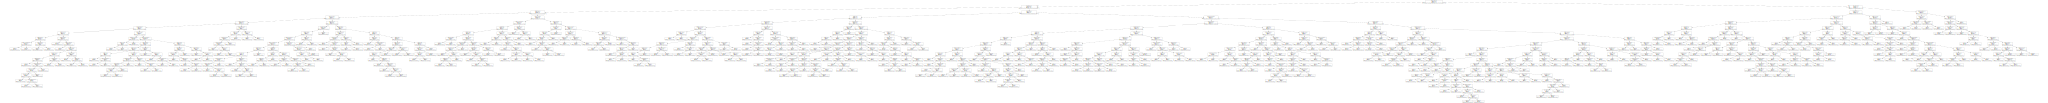

In [114]:
dot_data = tree.export_graphviz(best_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("best_tree")
#exportando
joblib.dump(best_tree, 'best_tree.pkl') 
graph

<h1> VALIDAÇÃO <h1>
Executar o código a partir daqui

### 4 - Resultados

In [ ]:
from sklearn.externals import joblib
import os
import numpy as np
import librosa, librosa.display
import scipy

best_tree = joblib.load('best_tree.pkl')

def normalizar(data) :
    
    #Definir valor máximo
    maximo = 0;
    if (max(data) > np.absolute(min(data))):
        maximo = max(data)
    else: 
        maximo = np.absolute(min(data))
    
    #Normalizar vetor entre -1 e 1
    x = 0
    while(x < len(data)):
        data[x] = data[x]/maximo
        x += 1
    
    return data

def separar_caracter(data, destination_array) :

    #Separar em 4 conjuntos 
    splited = []
    for i in range(4):
        start = int(i*len(data)/4)
        end = int((i+1)*len(data)/4)
        splited.append(data[start:end])
    
    frame_lenght = 3150 # frames de fs/14 aprox 0.5s
    
    chars_values = list()
    
    for audioPart in range(4):
        initial_frame_pos = 0 
        frames_list = list()

        #Separando os frames
        while initial_frame_pos < len(splited[audioPart]):
            frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
            initial_frame_pos += frame_lenght

        #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
        amp_cat_values = list()

        max_values = [max(x) for x in frames_list] 
        max_values.sort()
        max_value_mean = np.mean(max_values)
        max_value_std = np.std(max_values)

        for frame in frames_list:
            frame_max = max(abs(frame))
            #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
            if frame_max <= max_value_mean + max_value_std**2 :  
                if frame_max >= max_value_mean - max_value_std**2 :
                    amp_cat_values.append("max")
                else:
                    amp_cat_values.append("min")
            else:
                amp_cat_values.append("max")

        # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
        max_indexes = list()
        index_list = range(0, len(amp_cat_values))
        amp_cat_values = list(zip(index_list, amp_cat_values))

        max_indexes = [index for index in amp_cat_values if index[1] is "max"]

        #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
        chars_indexes = list()
        new_frame = list()
        new_frame.append(max_indexes[0])
        for frame_info in max_indexes:
            if frame_info[0] - new_frame[-1][0] <= 2:
                if frame_info not in new_frame:
                    new_frame.append(frame_info)
            else:
                chars_indexes.append(new_frame)
                new_frame = list()
                new_frame.append(frame_info)
            if frame_info is max_indexes[-1]:
                chars_indexes.append(new_frame)

        # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
        # caracteres validos
        initialBigger = 0
        lastBigger = 0

        diferenca = 0

        for index in chars_indexes:
            initial = index[0][0] 
            last = index[-1][0] 

            if (last - initial) > diferenca:
                initialBigger = initial
                lastBigger = last

        if (initialBigger != 0):
            initialBigger = initialBigger - 1
    
        #Obter uma frequencia de corte baseada em um conjunto que possui apenas o ruído
        
        corte = 0
        if (initialBigger != 0):
            corte = max(frames_list[initialBigger - 1])
        else:     
            corte = max(frames_list[lastBigger + 2])
            
        value = np.hstack(frames_list[initialBigger:lastBigger+1])
        
        #Remover o ruído com base no corte obtido anteriormente
        variavel = 0
        while(variavel < len(value)):
            if value[variavel] < 0:
                if corte > np.absolute(value[variavel]):
                    value[variavel] = 0
                else: 
                    value[variavel] = value[variavel] + corte
            else: 
                if corte > value[variavel]:
                    value[variavel] = 0
                else:
                    value[variavel] = value[variavel] - corte
            
            variavel = variavel+1
        
        destination_array.append(normalizar(value))

        
#carregando base de validação
Array_test = list()
Y_test = list()
for root, dirs, files in os.walk("base_validacao_I/"):  
    
    for filename in files:
        
        data, fs = librosa.load('base_validacao_I/' + filename, None)
        for s in range(4):
            Y_test.append(filename[s])
            
        separar_caracter(data, Array_test)
        
#extraindo informações
duration_test = np.array([len(x)/fs for x in Array_test])

tempo_beat_test = [librosa.beat.beat_track(y=x, sr=fs) for x in Array_test]
tempo_test = np.array([x[0] for x in tempo_beat_test])
beat_frame_test = np.array([x[1] for x in tempo_beat_test])

mean_percussive_test = np.array([librosa.effects.hpss(x)[1].mean() for x in Array_test])

#sftf_test = [librosa.stft(x) for x in Array_test]
fourier_test = [np.fft.fft(x) for x in Array_test]
mean_freq_test = np.array([np.abs(x).mean() for x in fourier_test])
freq_QT50_test = [np.percentile(np.abs(x), 50) for x in fourier_test]
freq_QT75_test = [np.percentile(np.abs(x), 75) for x in fourier_test]
freq_QT25_test = [np.percentile(np.abs(x), 25) for x in fourier_test]

mean_centroid_test = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in Array_test]

#Médias
mean_0_20_test = []
mean_20_40_test = []
mean_40_60_test = []
mean_60_80_test = []
mean_80_100_test = []

for x in Array_test:
     
    splited = []
    for i in range(5):
        start = int(i*len(x)/5)
        end = int((i+1)*len(x)/5)
        splited.append(x[start:end])
    
    mean_0_20_test.append(np.mean(np.absolute(splited[0])))
    mean_20_40_test.append(np.mean(np.absolute(splited[1])))
    mean_40_60_test.append(np.mean(np.absolute(splited[2])))
    mean_60_80_test.append(np.mean(np.absolute(splited[3])))
    mean_80_100_test.append(np.mean(np.absolute(splited[4])))

test_base = list(zip(
    duration_test,
    tempo_test, 
    mean_percussive_test, 
    mean_freq_test, 
    mean_centroid_test, 
    freq_QT50_test, 
    freq_QT75_test, 
    freq_QT25_test,
    mean_0_20_test,
    mean_20_40_test,
    mean_40_60_test,
    mean_60_80_test,
    mean_80_100_test))[::-1]
Y_test = Y_test[::-1]


def validar():
    strings_corretos = 0
    strings_errados = 0
    
    caracteres_corretos = 0
    caracteres_errados = 0 
    
    comprimento_base = len(test_base)/4 
    
    while len(test_base) != 0:
        primeiro_caracter = np.array(test_base.pop())
        segundo_caracter = np.array(test_base.pop())
        terceiro_caracter = np.array(test_base.pop())
        quarto_caracter = np.array(test_base.pop())
        
        string_primeiro_caracter_predita = best_tree.predict([primeiro_caracter])[0]
        string_segundo_caracter_predita = best_tree.predict([segundo_caracter])[0]
        string_terceiro_caracter_predita = best_tree.predict([terceiro_caracter])[0]
        string_quarto_caracter_predita = best_tree.predict([quarto_caracter])[0]
        
        
        string_primeiro_caracter = Y_test.pop()
        string_segundo_caracter = Y_test.pop()
        string_terceiro_caracter = Y_test.pop()
        string_quarto_caracter = Y_test.pop()
        
        string_predita = string_primeiro_caracter_predita + string_segundo_caracter_predita + string_terceiro_caracter_predita + string_quarto_caracter_predita
        
        string_real = string_primeiro_caracter + string_segundo_caracter + string_terceiro_caracter + string_quarto_caracter

        if string_primeiro_caracter == string_primeiro_caracter_predita:
            caracteres_corretos += 1
        else:
            caracteres_errados += 1
            
        if string_segundo_caracter == string_segundo_caracter_predita:
            caracteres_corretos += 1
        else:
            caracteres_errados += 1
            
        if string_terceiro_caracter == string_terceiro_caracter_predita:
            caracteres_corretos += 1
        else:
            caracteres_errados += 1
            
        if string_quarto_caracter == string_quarto_caracter_predita:
            caracteres_corretos += 1
        else:
            caracteres_errados += 1

        
        print("Arquivo " + string_real + " classificado como: " + string_predita )
        if string_predita == string_real:
            strings_corretos += 1
        elif string_predita != string_real:
            strings_errados += 1
            
        else:
            print("ERRO")
    
    total_caracteres_individuais = caracteres_corretos - caracteres_errados
    acuracia_caracteres = format(caracteres_corretos/(comprimento_base*4), '.2f')
    total_strings_completas = strings_corretos - strings_errados
    acuracia_strings_completas = format(strings_corretos/comprimento_base, '.2f')
    
    print("TOTAL DE CLASSIFICAÇÕES: " + str(comprimento_base))
    print(str(caracteres_corretos) + " CARACTERES CORRETOS")
    print(str(caracteres_errados) + " CARACTERES ERRADOS")
    print("ACURACIA PARA CARACTERES INDIVIDUAIS: " + str(acuracia_caracteres))
    
    print(str(strings_corretos) + " CLASSIFICAÇÕES CORRETAS")
    print(str(strings_errados) + " CLASSIFICAÇÕES ERRADAS")
    print("DIFERENÇA DE " + str(total_strings_completas) )
    print("ACURACIA CLASSIFICAÇÕES DE ARQUVOS: " + str(acuracia_strings_completas))
    
validar()

### 5 -  Comentários Finais